In [33]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from itertools import product
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')
%matplotlib inline

data={}
data['air_reserve']=pd.read_csv('01.RawData/air_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
data['air_store_info']=pd.read_csv('01.RawData/air_store_info.csv')
data['air_visit_data']=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
data['date_info']=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
data['hpg_reserve']=pd.read_csv('01.RawData/hpg_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
data['hpg_store_info']=pd.read_csv('01.RawData/hpg_store_info.csv')
data['store_id_relation']=pd.read_csv('01.RawData/store_id_relation.csv')
data['sample_submission']=pd.read_csv('01.RawData/sample_submission.csv')
data['store_master']=pd.read_csv('02.CleanData/01.StoreRegion.csv')

data['air_visit_data'].loc[:,'log_visitors']=np.log(1+data['air_visit_data'].loc[:,'visitors'])
data['sample_submission'].loc[:,'air_store_id']=data['sample_submission'].loc[:,'id'].map(lambda x: x[:-11])
data['sample_submission'].loc[:,'visit_date']=pd.to_datetime(data['sample_submission'].loc[:,'id'].map(lambda x: x[-10:]))
data['visits_master']=pd.concat([data['air_visit_data'],data['sample_submission']]).groupby(['air_store_id','visit_date'])['log_visitors'].max().unstack()

TEST_PERIOD=42 
TRAINING_WINDOW_SCALE=21 
TRAINING_WINDOW_ROLLING=84 
TRAINING_WINDOW_OVERALL_MEDIAN=63 
TRAINING_WINDOW_OVERALL_MEAN=42 
START_DT=datetime(2017,3,12)
END_DT=min(START_DT+timedelta(days=TEST_PERIOD-1),data['visits_master'].columns.max())


In [60]:
def extrapolate_ts(x):
    if np.isnan(x).sum()>len(x)/2.0 or np.isnan(x).sum()==0:
        return x
    nans=np.isnan(x)
    f=x.nonzero()[0]
    x[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], x[~nans])
    return x

error_list=[]
for i in range(42):
    clean_series=data['visits_master'].loc[:,START_DT:END_DT].apply(extrapolate_ts,axis=1)
    clean_series=clean_series.apply(lambda x: np.real(np.fft.ifft(np.fft.fft(x.values,n=i+1),n=42)),axis=1)
    errors=np.sqrt(np.square(data['visits_master'].loc[:,START_DT:END_DT].apply(extrapolate_ts,axis=1)-clean_series).sum().sum())/len(clean_series)
    error_list.append(errors)

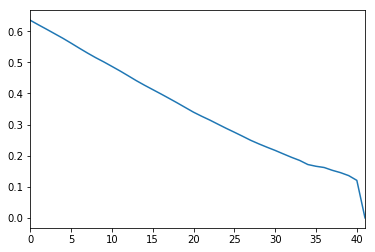

In [61]:
%matplotlib inline
pd.Series(error_list).plot()

In [62]:
error_list

[0.63537774766429478,
 0.62075951977311805,
 0.60655768047029479,
 0.59201528100670964,
 0.57745572222793051,
 0.56183206862115687,
 0.54581437740670713,
 0.53020869243824797,
 0.51536346857803916,
 0.50164998828337526,
 0.48709697092072263,
 0.47241509807102422,
 0.4568742865009619,
 0.44113417266335675,
 0.42651205526449448,
 0.41256299315788253,
 0.39864437618788223,
 0.38435068318119275,
 0.36982643732285431,
 0.35480110467319337,
 0.33986303923274269,
 0.32677825785748116,
 0.31444283452499322,
 0.3011479128909893,
 0.28798015476650185,
 0.27545004731589728,
 0.26264082642428804,
 0.24949297150048799,
 0.23801038612536224,
 0.22722355318502793,
 0.21692906783582627,
 0.20574383585560932,
 0.19478885794983877,
 0.18476264595742617,
 0.1716021576582151,
 0.16598184818281406,
 0.16202677595395543,
 0.15298629111276274,
 0.14552442356210632,
 0.13599927057808292,
 0.12069957262801283,
 9.1138600420152617e-16]

In [56]:
error_list

[526.72815281370038,
 514.60964189191486,
 502.83631710987436,
 490.78066795456226,
 478.71079372695442,
 465.75878488693905,
 452.48011887016025,
 439.54300603130758,
 427.23631545119446,
 415.86784028691812,
 403.80338889327908,
 391.63211630087909,
 378.74878350929743,
 365.70022913792275,
 353.57849381426593,
 342.01472132788462,
 330.47618785975436,
 318.62671635720881,
 306.58611654064623,
 294.1301157740773,
 281.74645952394371,
 270.89917576385187,
 260.67310982121938,
 249.65161978663011,
 238.73554830143004,
 228.34808922487886,
 217.72924510573478,
 206.82967337390454,
 197.31061009792529,
 188.36832559038817,
 179.83419723589998,
 170.56163992430012,
 161.47996324041634,
 153.16823349870629,
 142.25818869866032,
 137.59895214355285,
 134.32019726582905,
 126.82563533248032,
 120.63974713298613,
 112.74339530923075,
 100.05994570862264,
 7.5553899748306525e-13]

In [23]:
a=clean_series.iloc[0,:].values
print (a)
print (np.fft.fft(a))
print (np.real(np.fft.ifft(np.fft.fft(a))))

[ 3.68887945  3.68887945  3.36729583  3.76120012  3.68887945  3.63758616
  1.60943791  2.19539055  2.78134319  3.36729583  3.17805383  3.33220451
  3.55534806  2.07944154  2.93181559  3.78418963  3.4339872   3.97029191
  3.52636052  3.66356165  2.07944154  2.80290103  3.52636052  2.89037176
  3.58351894  3.40119738  2.89037176  2.30258509  2.59647843  2.89037176
  3.78418963  3.36729583  3.55534806  3.68887945  3.45783039  3.22678133
  2.99573227  3.58351894  2.89037176  3.66356165  4.02535169  2.94443898
  2.94443898]
[ 138.33277959+0.j            2.03076580+1.88861293j
    1.60370406+4.17124562j    2.69397167-3.33154523j
    2.16706765-2.2199586j     0.85752059+0.38287544j
   -7.31884017-6.25727512j   -1.59530763+3.56653514j
   -0.49126383+0.74073603j    1.62180958-0.89556077j
    2.76200112-0.56742259j    1.25270049-0.92367242j
    3.00614488-5.89378772j   -1.91153777-0.82097725j
    3.06892515+1.55791521j    0.25919588+1.23801054j
    1.14634898-0.14290122j   -0.82989238+3.55297949